In [1]:
import h5py
import sys
import time
sys.path.append("/users/munozr/mycodes")
import numpy as np
from pylab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import GetVars_Plot2d as GVar
from data_analysis_codes.tools import LinData
from matplotlib.collections import LineCollection
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)
from data_analysis_codes.tools.lineint import lineint

In [2]:
param32 = RRead.read_parameters('pflrw_d3e2_L1206_t1_N32_EdS_GRH_spin_CPunc_MR')
Lin32 = LinData.LinData_Class(param32)
all_h5it32 = RRead.collect_h5iteration(Lin32.param)
all_h5it32 = all_h5it32[0::2]
L = param32['Lx']

 read time file


In [3]:
def make_big_array(data):
    N = [np.shape(d)[0] for d in data]
    xbig = np.arange(-L/2, L/2, param32['dx']/(2**(len(data)-1))) / L
    Nbig = len(xbig)
    big_data = np.zeros((Nbig, Nbig, Nbig))

    for rl in range(len(data)):
        dxg = param32['dx']/(2**rl)
        Lg = N[rl]*dxg
        xmin = (-Lg/2 + (dxg/2)*(N[rl]%2))/L
        imin = np.argmin(abs(xbig - xmin))
        nrepeat = 2**(3-rl)
        imax = imin + N[rl]*nrepeat
        big_data[imin:imax, imin: imax, imin:imax] = np.repeat(np.repeat(np.repeat(
            data[rl], nrepeat, axis=0), nrepeat, axis=1), nrepeat, axis=2)
    return xbig, big_data

def cut(rl, data):
    if rl > 1:
        icut = 3
        return RRead.fixij(data[icut:-icut, icut:-icut, icut:-icut])
    else:
        return RRead.fixij(data)

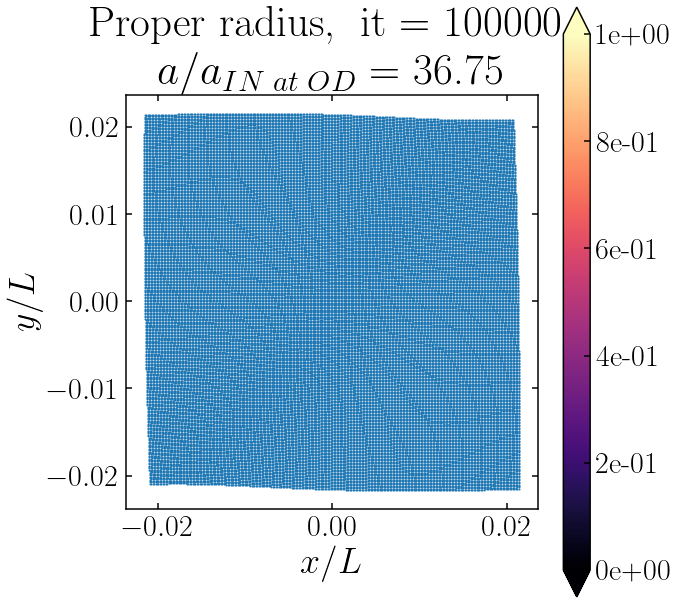

In [8]:
mpl.rcParams['font.size'] = 30

filename = '/users/munozr/simulations/' + param32['simname'] + '/proper_distance_weight.hdf5'
fw = h5py.File(filename, 'r') 

allit = np.append(np.arange(0, 73600, 200), 
                  np.arange(73800, 120000, 200))

for it in [100000]:#RRead.progressbar(allit):
    gdet_all = []
    for rl in range(0):
        f = h5py.File(param32['h5datapath']+param32['simname']+'_it_{:06d}.hdf5'.format(it),'r')
        gxx = cut(rl, np.array(f['ADMBASE::gxx it={} tl=0 rl={}'.format(it, rl)]))
        gxy = cut(rl, np.array(f['ADMBASE::gxy it={} tl=0 rl={}'.format(it, rl)]))
        gxz = cut(rl, np.array(f['ADMBASE::gxz it={} tl=0 rl={}'.format(it, rl)]))
        gyy = cut(rl, np.array(f['ADMBASE::gyy it={} tl=0 rl={}'.format(it, rl)]))
        gyz = cut(rl, np.array(f['ADMBASE::gyz it={} tl=0 rl={}'.format(it, rl)]))
        gzz = cut(rl, np.array(f['ADMBASE::gzz it={} tl=0 rl={}'.format(it, rl)]))
        tauOD = np.array(f['COSMOLAPSE::tau it={} tl=0 rl=0'.format(it)])[16,16,16]
        f.close()
        
        N = np.shape(gxx)[0]
        gdown = np.array([[gxx, gxy, gxz],
                          [gxy, gyy, gyz],
                          [gxz, gyz, gzz]])
        del gxx, gxy, gxz, gyy, gyz, gzz

        gdet_all += [RRead.det3(gdown)]
        del gdown
    xbig, big_gdet = make_big_array(gdet_all)
    del gdet_all
    
    # code coord
    N = len(xbig)
    d3xc, d3yc, d3zc = np.meshgrid(xbig, xbig, xbig, indexing='ij')
    xic = np.array([d3xc, d3yc])
    
    # proper coord    
    iz = int(N/2)
    xp = []
    yp = []
    for ix in range(N):
        for iy in range(N):
            idx = '({},{},{})'.format(ix,iy,iz)
            segments = np.array(fw[idx+' segments'])
            indices = np.array(fw[idx+' indices'])
            pradius = np.sum([big_gdet[tuple(indices[i])]*segments[i]
                                        for i in range(len(segments))])
            
            cradius = np.sqrt(d3xc[ix,iy,iz]**2 + d3yc[ix,iy,iz]**2)
            phi = np.arccos(RRead.safe_division(d3xc[ix,iy,iz], cradius))
            if d3yc[ix,iy,iz]<0:
                phi = 2*np.pi - phi
            if d3xc[ix,iy,iz]==0 and d3yc[ix,iy,iz]==0:
                phi = 0

            xp += [pradius * np.cos(phi)]
            yp += [pradius * np.sin(phi)]
    
    icent = iz
    plt.figure(figsize=(10,10))
    #plt.pcolormesh(xbig, xbig, big_data[:,:,icent], shading='gouraud')
    plt.scatter(xp, yp, s=1)
    plt.colorbar(format='%.0e', extend='both')
    plt.xlabel(r'$x/L$')
    plt.ylabel(r'$y/L$')
    plt.title(r'Proper radius,$\;$ it = '+r'{},$\;$ '.format(it)
              + '\n' + r'$a/a_{IN \; at \; OD}$ = ' + '{:.2f}'.format(Lin32.an_initial(tauOD)))
    plt.gca().set_aspect("equal")
    plt.tight_layout()
    #plt.savefig('/users/munozr/simulations/' + param32['simname'] + '/PRadius_it={:06d}'.format(it))
    #plt.close(plt.gcf())
fw.close()